Raschka, Sebastian and Mirjalili, Vahid, 2020, _Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition_, Birmingham, Packt Publishing.（株式会社クイープ訳，福島真太朗監訳，2020，『［第3版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践』インプレス．）

In [1]:
# 注意:
# マークダウン部分… テキストに書かれていること
# コード部分… ほぼテキストに書かれている通り
# コメント部分… ほぼ発表者のきもち

# 準備

In [2]:
from IPython.display import Image
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import __version__ as scipy_version
if scipy_version >= '1.4.1':
    from numpy import interp
else:
    from scipy import interp

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

# 6.1 パイプラインによるワークフローの効率化

## 6.1.1 Breast Cancer Wisconsin データセットを読み込む

In [3]:
# 腫瘍にまつわるデータを読み込み、データのサイズを確認する
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
display(df)
print(df.shape)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


(569, 32)


In [4]:
# 参考までに①

# カラムに名前をつける(github上のリファレンス wdbc.names.txtより）
hd = ['ID', '診断']
bd = ['半径', 
     'テクスチャ', 
     '周囲', 
     '面積', 
     '滑らかさ',
     'コンパクト性', 
     '凹み度', 
     '凹み点', 
     '対称性', 
     'フラクタル次元']
tl = ['_平均', '_標準誤差', '_最悪']
bdtl = [i + j for j in tl for i in bd]
col_name = hd + bdtl
df_tmp = df.set_axis(col_name, axis=1)
display(df_tmp.head(3))

,ID,診断,半径_平均,テクスチャ_平均,周囲_平均,面積_平均,滑らかさ_平均,コンパクト性_平均,凹み度_平均,凹み点_平均,...,半径_最悪,テクスチャ_最悪,周囲_最悪,面積_最悪,滑らかさ_最悪,コンパクト性_最悪,凹み度_最悪,凹み点_最悪,対称性_最悪,フラクタル次元_最悪
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


変数についての説明: 

---

1 ID番号

2 診断名（M＝悪性、B＝良性）

3 - 32<br>
各細胞核に対して、10個の実数値特徴量を計算する。

	a) 半径 (中心から外周の点までの距離の平均)
	b) テクスチャー (グレースケール値の標準偏差)
	c) 周囲
	d) 面積
	e) 滑らかさ (半径の長さの局所的なばらつき)
	f) コンパクト性 (外周^2 / 面積 - 1.0)
	g) 凹み度 (輪郭の凹んだ部分の度合い)
	h) 凹点(輪郭の凹んだ部分の数)
	i) 対称性 
	j) フラクタル次元（「海岸線近似」-1）

上述の論文うちいくつかは、これらの特徴がどのように計算されているのかが詳細に記述している。<br>
各画像において、これらの特徴量それぞれの平均値、標準誤差、「最悪」または最大値（最大値3つの平均値）を計算した。よって、30個の特徴量となる。 <br>
例えば、フィールド3は半径の平均、フィールド13は半径の標準誤差、フィールド23は半径の最悪値である。<br>
すべての特徴量は有効数字4桁で記録されている。

---
出典: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/wdbc.names.txt

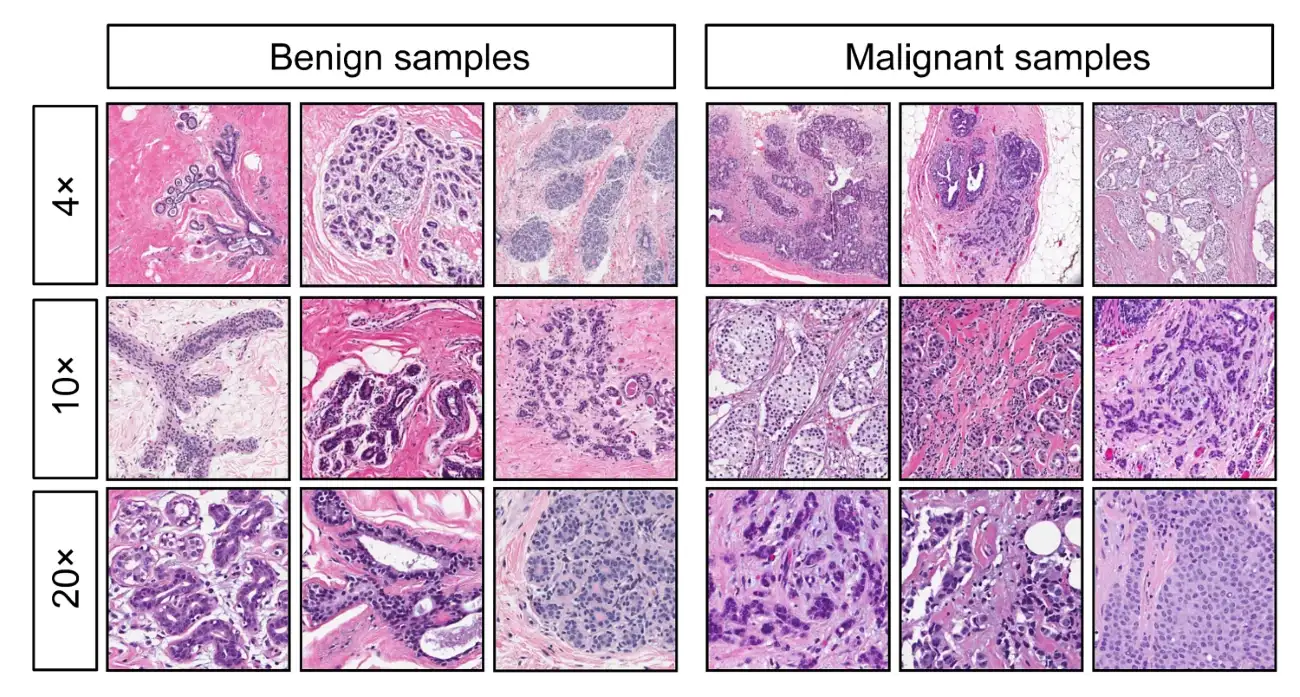

In [5]:
# 参考までに②

# 腫瘍細胞の画像の例をネットで拾って見てみる ※あくまでイメージです
url='https://miro.medium.com/max/1400/1*pxFCmhRFTighUn88baLcSA.webp'
my_header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:88.0) Gecko/20100101 Firefox/88.0'}
Image(data=requests.get(url, headers=my_header).content, width = 600, height = 600)
# 出典: https://doi.org/10.1371/journal.pone.0141357.g002

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
dtype: bool



B    0.627417
M    0.372583
Name: 診断, dtype: float64

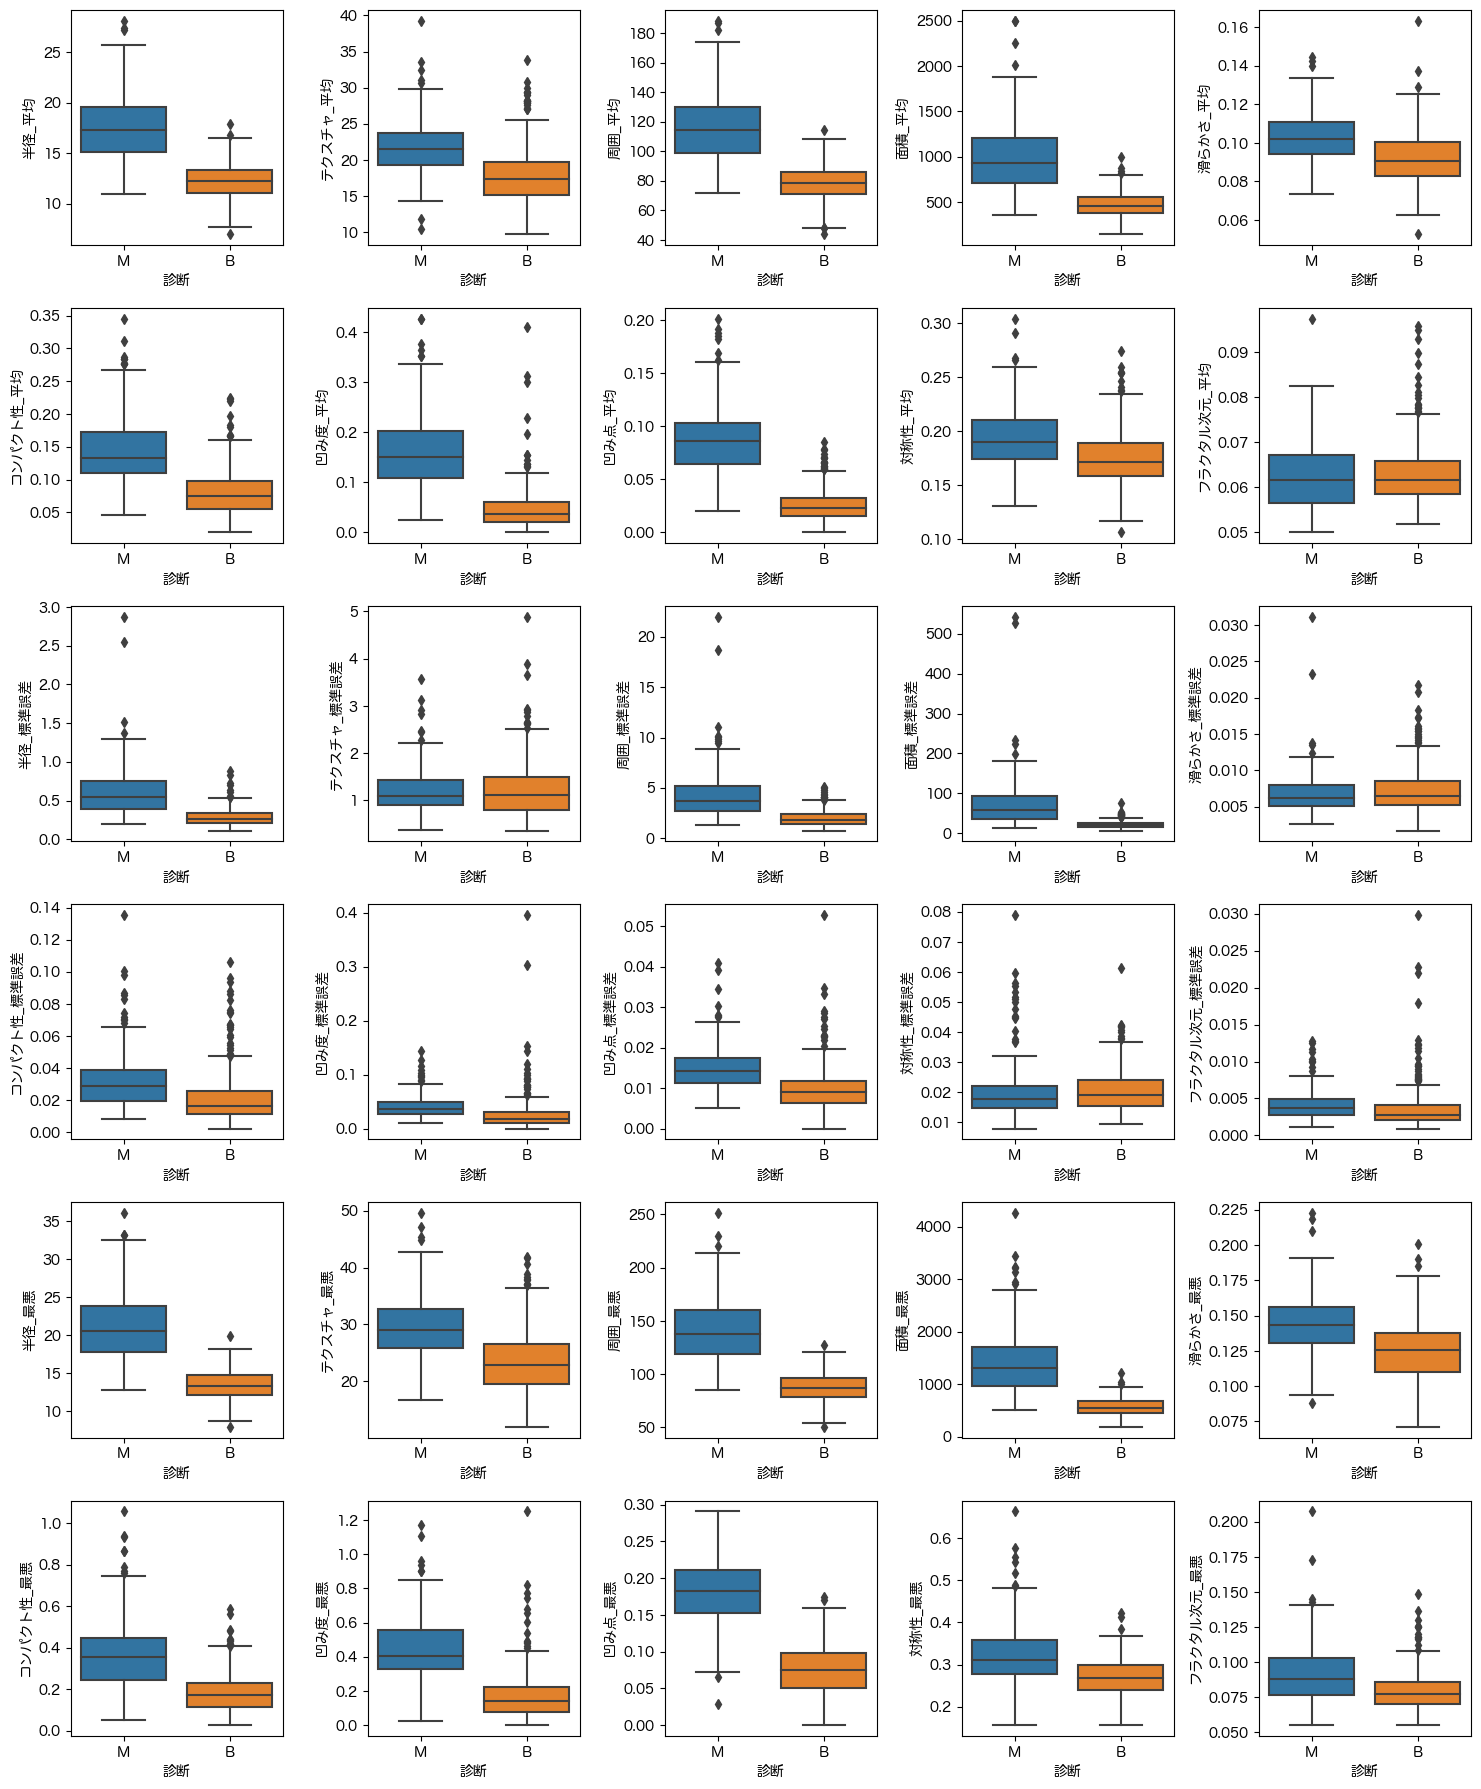

In [6]:
# 参考までに③

# 欠損値の有無とクラスの比率を確認する
print(df.isna().any(), end='\n\n')
display(df_tmp['診断'].value_counts(dropna=False, normalize=True))

# 良性/悪性で分けた箱ヒゲ図を描く
fig =plt.figure(figsize=[15,18])
for i in range(1, 31):
    axi = plt.subplot(6,5,i)
    sns.boxplot(x="診断", y=df_tmp.iloc[:, i+1], data=df_tmp, ax=axi)
plt.tight_layout() # 体裁をきれいにするおまじない
plt.show()

In [7]:
# 30個の特徴量をNumpy配列xに割り当てる
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y) # LabelEncoderのfit_transformメソッドで目的変数を['B', 'M']から[0, 1]へ変換する
display(le.classes_)

# 変換できているか確認する
display(y[20:26])

array(['B', 'M'], dtype=object)

array([0, 0, 1, 1, 1, 1])

In [8]:
# ランダムに学習用データ(80%)、テスト用データ(20%)に割り当て、それぞれで説明変数と目的変数に分ける
# 実際には、完全にランダムにすると、テスト用データが全部良性、みたいなことがふつうに起きてしまう
# よって、stratify=yで、分割後のサブグループの中の比率も、もとのデータの良性/悪性の比率を維持するように指定する
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y, 
                     random_state=1)

## 6.1.2 パイプラインで変換器と推定器を結合する

In [9]:
# Pipelineクラスをインスタンス化： pipe_lrインスタンスを作成する
# StandardScaler、PCA、LogisticRegressionを結合している
pipe_lr = make_pipeline( # make_piplineはPipelineクラスの新たなインスタンスの作成を簡略化するラッパー関数
    StandardScaler(), # すべての変数について0~1の範囲に揃える標準化器をセットする
    PCA(n_components=2), # 0次元を2次元に圧縮する主成分分析器をセットする
    LogisticRegression(random_state=1, solver='lbfgs')) # 予測器としてL-BFGS法によるロジスティック回帰をセットする

# pipe_lrに学習用データを渡して学習させる
pipe_lr.fit(X_train, y_train) 
y_pred = pipe_lr.predict(X_test)

# 学習用データでのモデルの正解率を表示する
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


In [10]:
# ロジスティック回帰分析について

# 6.2 k分割交差検証を使ったモデルの性能の評価

In [11]:
# モデルが単純すぎると学習不足（バイアスが高い）、複雑すぎると過学習（バリアンスが高い）に陥ることがある
# 詳しくは「3.3.5 正則化による過学習への対処」
# バイアスとバリアンスのバランスをとるため、モデルを入念に評価する必要がある。そのための２つの評価法が
# ホールドアウト法
# k分割交差検証

## 6.2.1 ホールドアウト法

In [12]:
# データの一部を「差し出す、提供する(hold out)」。
# ホールドアウト法は、今まですでに使ってきた、データを学習用データ(80%)とテスト用データ(20%)とかに分けて使う方法。
# ここでの強調点は、パラメータの推定にだけでなく、ハイパーパラメータチューニングにも学習用データを使ったら、より過学習になるよということ。
# したがって、学習用データ(60%)とハイパーパラメータチューニング用データ(20%)とテスト用データ(20%)に分けるのがより良いと言っている。
# ハイパーパラメータをチューニングし「最適な」値を選択することを「モデル選択」ともいう。

In [13]:
# ハイパーパラメータとは
# 出てくるのはロジスティック回帰（tol, C, loss_weightなど）、決定木（max_depth, min_sample_split, min_sample_leefなど)など

## 6.2.2 k分割交差検証

In [14]:
# k分割交差検証は、3分割版ホールドアウト法を拡張したもの
# データを学習用データ(80%)とテスト用データ(20%)とかに分けたのち、
# 学習用データをさらに10分割して、学習用データ(72%)とハイパーパラメータチューニング用データ(8%)でチューニングを行うのを、
# 10回繰り返す。
# 締めに学習用データ(80%)全体でチューニングする。
# 最後にテスト用データ(20%)でモデルの最終的な性能を評価する。


In [15]:
# 層化k分割交差検証を理解するには、
# 層化を理解したほうがはやい。
# クラスの比率が偏っている（たとえばデータのなかで目的変数である性別の比率が男80%女20%だったときとか）に、
# 評価のバイアスとバリアンスが改善する。

In [16]:
# 他の交差検証法として、ブートストラップ交差検証などがある(p.176)

# 6.3 学習曲線と検証曲線によるアルゴリズムの診断

## 6.3.1 学習曲線を使ってバイアスとバリアンスの問題を診断する

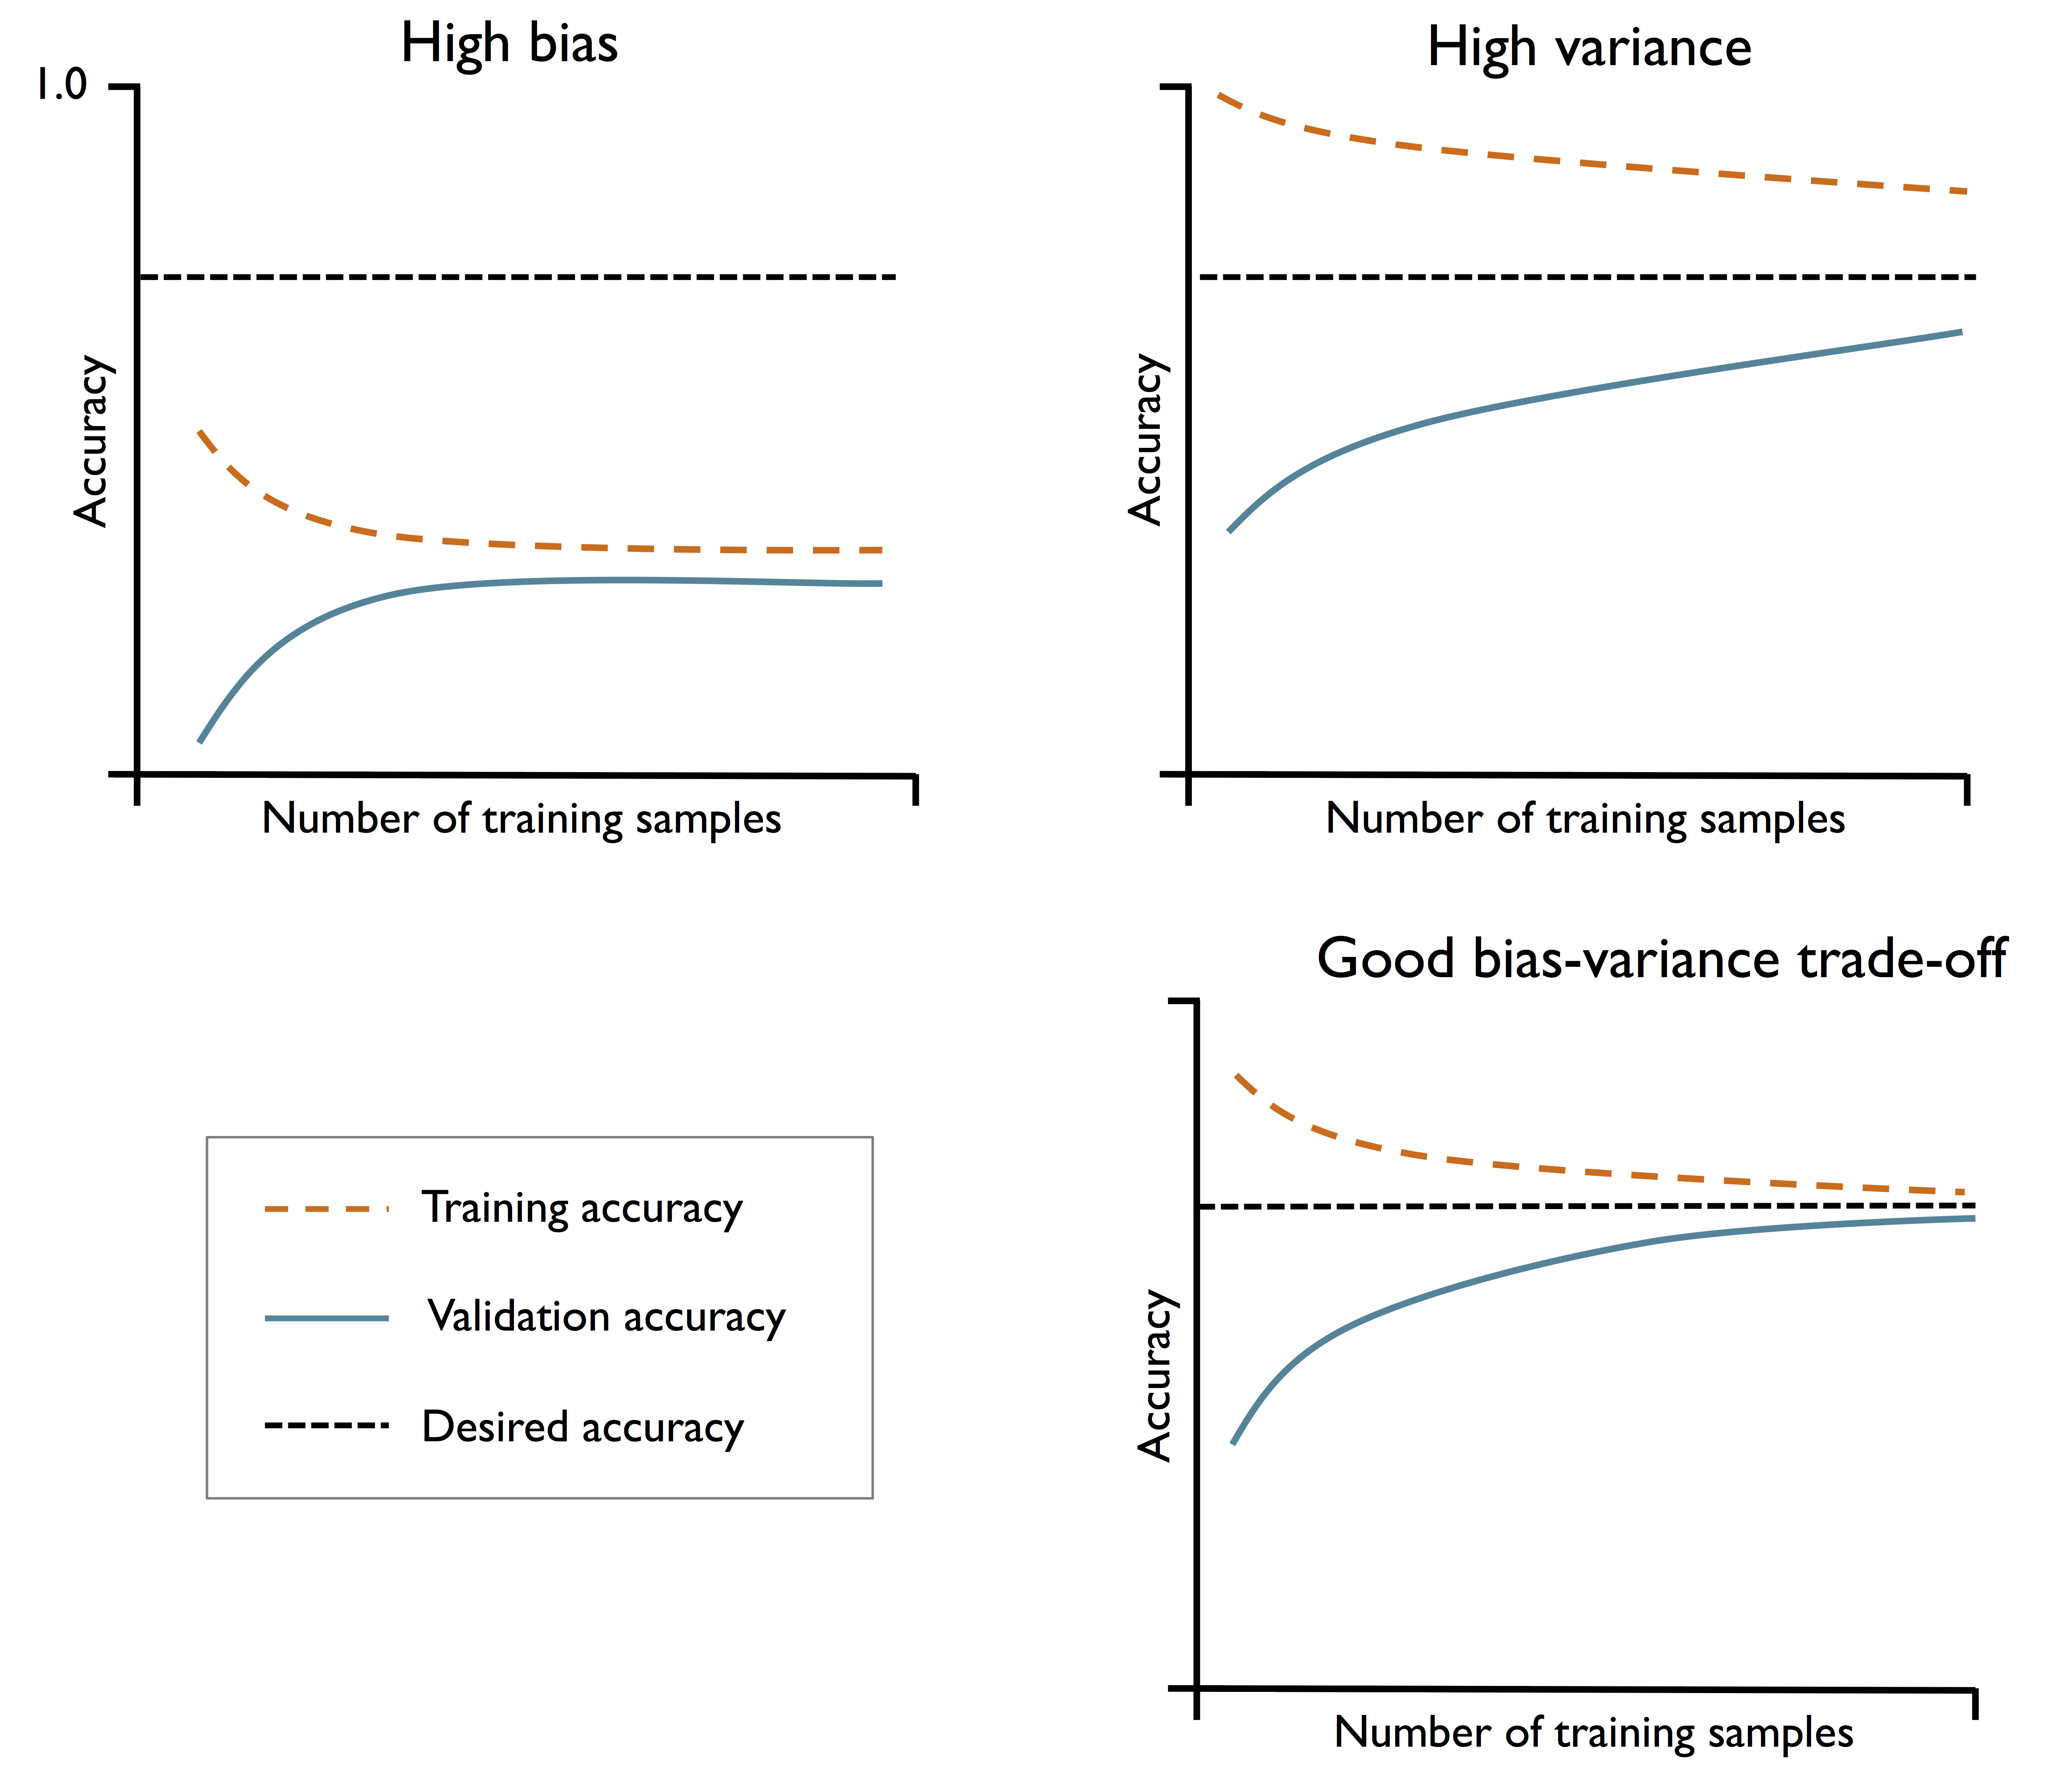

In [17]:
url='https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch06/images/06_04.png'
my_header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:88.0) Gecko/20100101 Firefox/88.0'}
Image(data=requests.get(url, headers=my_header).content, width = 600, height = 600)
# 出典: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_04.png

## 6.3.2 検証曲線を使って過学習と学習不足を明らかにする

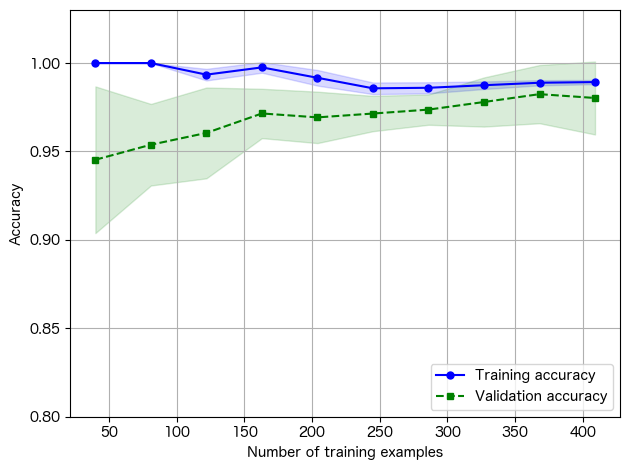

In [18]:
'''
使うデータを増やすと正解率がどう変わるのか実験し、可視化している。
持っているデータの10%を使う、20%を使う、…、100%を使う、というふうに増やしていく。
なお、10分割の交差検証を使っている。
'''

## ↓これ完成させる
'''
LogisticRegressionのpenaltyパラメータは‘l1’, ‘l2’, ‘elasticnet’, ‘none’の４種類あって、デフォルトはl2。

L1 (Rasso)
いくつかの特徴量を0にしてしまって過学習を防ぐやり方
課題としてサンプル数nより特徴量pが大きい場合、pの取れる最大値はnになってしまう

L2 (Ligge)
数値の絶対量を減らすことで過学習を防ぐやり方。イメージとして標準化と同じ？

elasticnet
L1,L2の両方を使用して使うやり方。L1とL2bの前に重みをつけることによって最適な値を回数を回すことで求めようとするやり方。
L1が使えてないのであれば、L２に自動的に切り替えてほしかったけどそういうわけにもいかないのかな
とりあえずこれを使えばいいと思うのだけれどdefaultがl2なのでなんらかの欠点があるのかもしれない

NONE
多分なんの正則化も行なっていない

公式に出てくる‘newton-cg’とかは最適化問題に使う関数の種類のこと。使える組み合わせと使えない組み合わせがあるっぽい。
'''
pipe_lr = make_pipeline( # pipe_lrインスタンスを作成する
    StandardScaler(), # 標準化器をセットする
    LogisticRegression( # ロジスティック回帰予測器をセットする
        penalty='l2',
        random_state=1, 
        solver='lbfgs',
        max_iter=10000
        # max_iter: 学習の試行の最大数。
        # この試行数かtolで指定した値よりもスコアの向上値が小さくなるのが続いたら、学習が終了する。
        # デフォルト値は1000。
        # なぜこの値を大きくするかというと、データセットのサイズが小さい場合や正則化パラメータの値が極端な場合の収束問題を回避するため。
        # 詳しくは次項で取り上げるらしい(p.178)。
    )
)

# learning_curve関数で交差検証により予測器の正解率を算出する。
# 学習に使ったデータサイズ(割合)、学習用データでの正解数、テスト用データでの正解数を収容する。
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr, # 予測器としてpipe_lインスタンスを指定する
                               X=X_train, # 学習用データをわたす
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1, 10), # train_sizeがたとえば0.1なら、学習用データの10%を使うということ # 0.1から1までを10等分した数列を用意する
                               cv=10, # cross validationする回数、つまり分割数を指定する
                               n_jobs=1) # CPUに並列処理させる数を指定する

train_mean = np.mean(train_scores, axis=1) # 学習用データでの正解数の平均
train_std = np.std(train_scores, axis=1) # 学習用データでの正解数の標準偏差
test_mean = np.mean(test_scores, axis=1) # テスト用データでの正解数の平均
test_std = np.std(test_scores, axis=1) # テスト用データでの正解数の標準偏差

# 横軸:データのサイズ、縦軸:正解率 のグラフを描く
plt.plot(train_sizes, train_mean, # 学習用データでの正解数の平均と標準偏差をグラフにプロットする
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, # 1S区間をぬりつぶす
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, # テスト用データでの正解数の平均と標準偏差をグラフにプロットする
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes, # 1S区間をぬりつぶす
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
# グラフの体裁を整える
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout() # 体裁をきれいにするおまじない
plt.show()

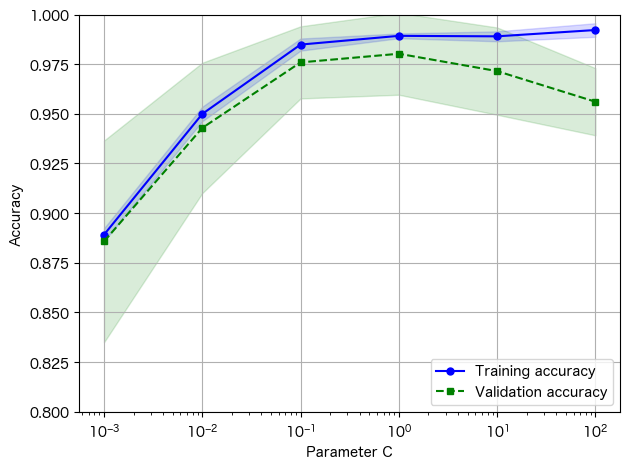

In [19]:
'''
ハイパーパラメータを１つ選び、その値を変えていくと正解率がどう変わるのか実験し、可視化している。
ロジスティック回帰のハイパーパラメータであるCを、0.001, 0.01, 0.1, 1, 10, 100の6パターンで試している。
10分割の交差検証を使っている。
なお、今回使うデータサイズは100%で一定。
'''

# ハイパーパラメータCの候補を準備する
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# validation_curve関数で交差検証により予測器の正解率を算出する。
# 学習に使ったデータサイズ(割合)、学習用データでの正解数、テスト用データでの正解数を収容する。
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, # パイプラインは前に作ったものを流用
                X=X_train, # 学習用データを渡す
                y=y_train, 
                param_name='logisticregression__C', # Cで実験しますよ、と指定する
                param_range=param_range, # Cの候補を渡す
                cv=10) # 10分割で交差検証する

train_mean = np.mean(train_scores, axis=1) # 学習用データでの正解数の平均
train_std = np.std(train_scores, axis=1) # 学習用データでの正解数の標準偏差
test_mean = np.mean(test_scores, axis=1) # テスト用データでの正解数の平均
test_std = np.std(test_scores, axis=1) # テスト用データでの正解数の標準偏差

# 横軸:Cの値、縦軸:正解率 のグラフを描く
plt.plot(param_range, train_mean, # 学習用データでの正解数の平均と標準偏差をグラフにプロットする
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, # 1S区間をぬりつぶす
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,  # テスト用データでの正解数の平均と標準偏差をグラフにプロットする
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')
plt.fill_between(param_range, # 1S区間をぬりつぶす
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# グラフの体裁を整える
plt.grid()
plt.xscale('log') # 横軸の表記を10^nに変更する
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout() # 体裁をきれいにするおまじない
plt.show()

# C=0.01~0.1のあたりが最適とわかる

# 6.4 グリッドサーチによる機械学習モデルのチューニング

## 6.4.1 グリッドサーチをつかったハイパーパラメータのチューニング

In [20]:
'''
複数のハイパーパラメータを変えていく正解率がどう変わるのか実験している。
モデルは線形カーネルSVMとRBFカーネルSVMの２つ。
線形カーネルではCだけ、
RBFカーネルではC, gammaを変えていく。

Cとgammaをそれぞれ0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000の8パターンで動かすので、
RBFカーネルのほうでは合計64通りを試すことになる。

SVM（サポートベクターマシン）とは、データを分類して境界線を引くための教師あり学習アルゴリズム(第３章)。

Cとは、

gammaとは、

'''

pipe_svc = make_pipeline( # pipe_svcインスタンスを作成する
    StandardScaler(), # 標準化器をセットする
    SVC(random_state=1))# SVM予測器をセットする

# ハイパーパラメータの候補を作成する
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# 線形カーネルとRBFカーネルそれぞれで準備する
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# GridsearchCVクラスをインスタンス化: gsインスタンスを作成
gs = GridSearchCV(estimator=pipe_svc, # 予測器としてpipe_svcを渡す
                  param_grid=param_grid, # ハイパーパラメータの候補を渡す
                  scoring='accuracy', # 正解率で競わせる
                  refit=True, # Trueだと最良だったパラメータを使い学習用データ全体で再学習する
                  cv=10, # 10分割で交差検証する
                  n_jobs=-1) # CPUをフルに使う

# 学習用データを渡し、グリッドサーチを実行
gs = gs.fit(X_train, y_train)
print('最良スコア:', gs.best_score_, '\nその時のパラメータ:', gs.best_params_)

最良スコア: 0.9846859903381642 
その時のパラメータ: {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


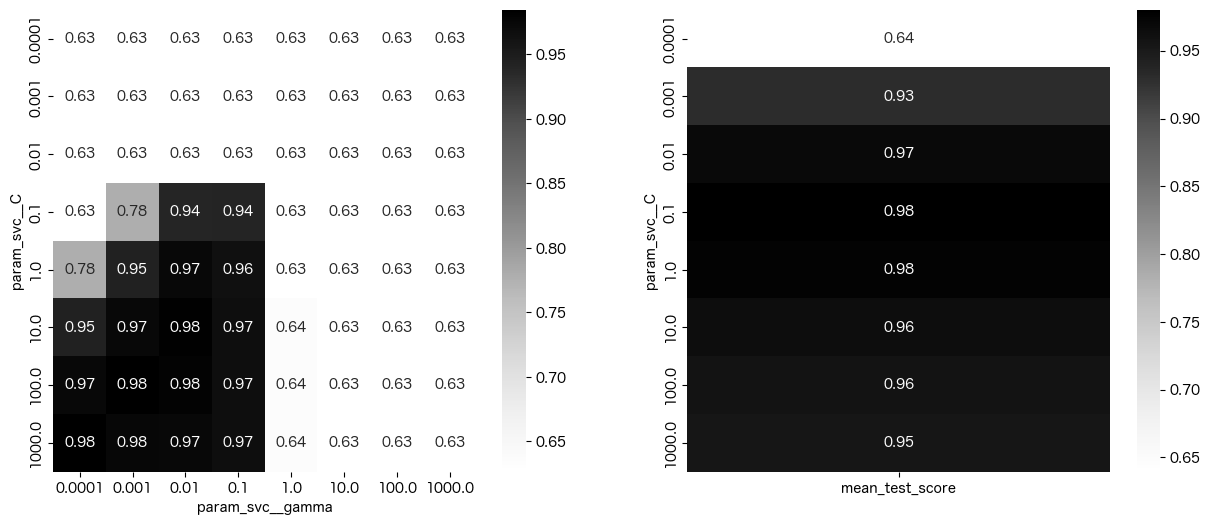

In [21]:
# 当然ヒートマップで示したくなる
# 検証曲線の２次元バージョンと考えればよい
cv_result = pd.DataFrame(gs.cv_results_)
'''
cv_resultに入っているもの: 
[
'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
'param_svc__C', 'param_svc__kernel', 'param_svc__gamma', 'params',
'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score',
'mean_test_score', 'std_test_score',
'rank_test_score'
]

mean_fit_time: 学習時間の平均
mean_score_time: 推論時間の平均
mean_test_score: テスト精度の平均
param_XXX: 名前がXXXであるパラメータの値
params: 各パラメータの値
rank_test_score: テスト精度の順位
split_test_score: 回目の交差検証のテスト精度
std_fit_time: 学習時間の標準偏差
std_score_time: 推論時間の標準偏差
std_test_score: テスト精度の標準偏差
'''
cv_result_rbf = cv_result[cv_result['param_svc__kernel'] == 'rbf']
cv_result_linear = cv_result[cv_result['param_svc__kernel'] == 'linear']

cv_result_pivot_rbf = cv_result_rbf.pivot_table('mean_test_score', 'param_svc__C', 'param_svc__gamma')
cv_result_pivot_linear = cv_result_linear.pivot_table('mean_test_score', 'param_svc__C')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # プロットエリアを準備する

# 左: RBFカーネルでの、パラメータ（２つ）による正解率の違い
heat_map = sns.heatmap(cv_result_pivot_rbf, cmap='Greys', annot=True, ax=ax1)
# 右: 線形カーネルでの、パラメータ（１つ）による正解率の違い
heat_map = sns.heatmap(cv_result_pivot_linear, cmap='Greys', annot=True, ax=ax2)

In [22]:
# 上の２つの図から、「svc_Cはとりあえずは10~100くらいにしとくとよさそう」という教訓が得られる
# svc_gammaは0.001~0.01くらい？

In [23]:
# ベストチューニングされたモデルの、テスト用データにおける正解率を表示する
clf = gs.best_estimator_
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


## 6.4.2 入れ子の交差検証によるアルゴリズムの選択

In [24]:
# k分割交差検証とグリッドサーチを入れ子にした方法。
# 上のグリッドサーチとの違いは、データの分割に関して、シャッフル回数が増えること。
# 実は上のグリッドサーチでは、ハイパーパラメータの計64種類の組み合わせについて、データの分割は1度しか行われていない。使い回し。
# 今回はデータの分割を5回行って、それぞれについてさらに2分割しハイパーパラメータのチューニングを行う。
# 外側ではチューニングされたモデルをつかって5種類の学習をすることになる。

# SVCバージョン
# 内側ループ: ハイパーパラメータを2分割でチューニングする
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
# 外側ループ: チューニングされたモデルを使って5分割で学習する
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

# 決定木バージョン
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015
CV accuracy: 0.934 +/- 0.016


# 6.5 さまざまな性能評価指標

In [25]:
# これまでは、モデルを評価する指標として、正解率をもちいてきた。
# ここからは、代替となりうる、適合率と再現率、F1スコアを扱っていく。

## 6.5.1 混同行列を解釈する

In [26]:
# そのまえに: 
# 混合行列とは、ある分類器について、その予測における、真陽性数、真陰性数、偽陽性数、偽陰性数をまとめた正方行列である。

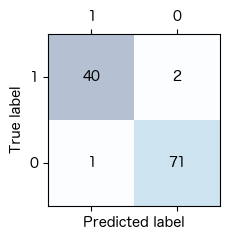

In [27]:
# 混合行列を作って図にする

# 混合行列を作る
pipe_svc.fit(X_train, y_train) # グリッドサーチでも使用したパイプラインを学習用データで学習させる
y_pred = pipe_svc.predict(X_test) # テスト用データで予測させる
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred) # 予測結果と正解とを渡して混合行列を作る

# プロットエリアとグラフの骨組みの準備
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

# 混合行列の中身(真陽性数、真陰性数、偽陽性数、偽陰性数)を１つずつ書き込む
# そのままだと(0,0)が左上、(1,1)が右下にきてしまうので、反転処理を行っている
for i in range(confmat.shape[0]): # 行の数だけくりかえす
    for j in range(confmat.shape[1]): # 列の数だけくりかえす
        ax.text(x=1-j, y=1-i, s=confmat[i, j], va='center', ha='center') # x=…, y=…で書き込む位置を指定する。sは書き込む文字。
        plt.xticks([1-i, i], [i, 1-i])
        plt.yticks([1-j, j], [j, 1-j])

# 体裁を整える
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout() # 体裁をきれいにするおまじない

plt.show()

## 6.5.2 分類モデルの適合率と再現率を最適化する

In [28]:
# 用語の説明

正解率(ACC)… 全体に占める、予測が当たっていた割合
$$
正解率(ACC) = \frac{真陽性数+真陰性数}{真陽性数+真陰性数+偽陽性数+偽陰性数}
$$

誤分類率(ERR)… 全体に占める、予測が間違っていた割合
$$
誤分類率(ERR) = \frac{偽陽性数+偽陰性数}{真陽性数+真陰性数+偽陽性数+偽陰性数}\
$$

当然、
$$
誤分類率(ERR) = 1 - 正解率(ACC)
$$

真陽性率(TPR)… 実際は陽性だったひとに占める、ちゃんと陽性判定が出る割合
$$
真陽性率(TPR) = \frac{真陽性数}{真陽性数+偽陰性数}
$$

偽陽性率(FPR)… 実際は陰性だったひとに占める、陽性判定になってしまう割合
$$
偽陽性率(FPR) = \frac{偽陰性数}{真陰性数+偽陽性数}
$$

再現率(Recall, 感度)… 実際は陽性だったひとに占める、ちゃんと陽性判定が出る割合。真陽性率(TPR)に等しい
$$
再現率(REC) = \frac{真陽性数}{真陽性数+偽陰性数}
= 真陽性率(TPR)
$$

適合率(Precision, 精度)… 陽性判定が出たひとに占める、本当に陽性の割合
$$
適合率(PRE) = \frac{真陽性数}{真陽性数+偽陽性数}
$$

In [29]:
# Recallは「再現率」ではなく「回収率」と訳した方がしっくりくる。

F1スコア… 再現率（REC)と適合率（PRE)の調和平均
$$
F1スコア = \frac{2}{\frac{1}{再現率} + \frac{1}{適合率}}
= \frac{適合率 × 再現率 × 2}{適合率 + 再現率}
$$

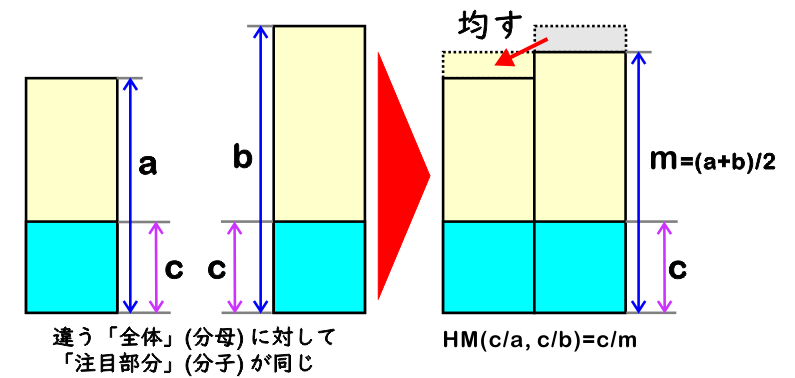

In [30]:
# 調和平均の説明

# 適合率と再現率は、分子は同じだが分母が違う。
# 分子は同じだが分母が違う食塩水を混ぜたときの濃度の求め方が、調和平均。

Image(data='https://www.cresco.co.jp/blog/wp-content/uploads/2019/11/mean3.png', width = 600, height = 600)
#出典: https://www.cresco.co.jp/blog/entry/10325/

In [31]:
# なぜF1スコアを使うのか

# 真陽性をとりこぼれなく陽性判定にしようとすると、偽陽性も増えてしまう、というトレードオフがある。
# 陽性判定がでたときに本当に真陽性である率を高めようとする（偽陽性を減らす）と、真陽性のとりこぼれが増えるというトレードオフがある。
# このように適合率と再現率のあいだにあるトレードオフのバランスをとるために、２つの平均的な指標をつくったのが、F1スコア。

In [32]:
# Scikit-learnのmetricsモジュールを使えば、適合率、再現率、F1スコアはかんたんに出せる

# グリッドサーチで使ったSVCモデルの、テスト用データに対する予測の性能を表示する
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


0.9880771478667446
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


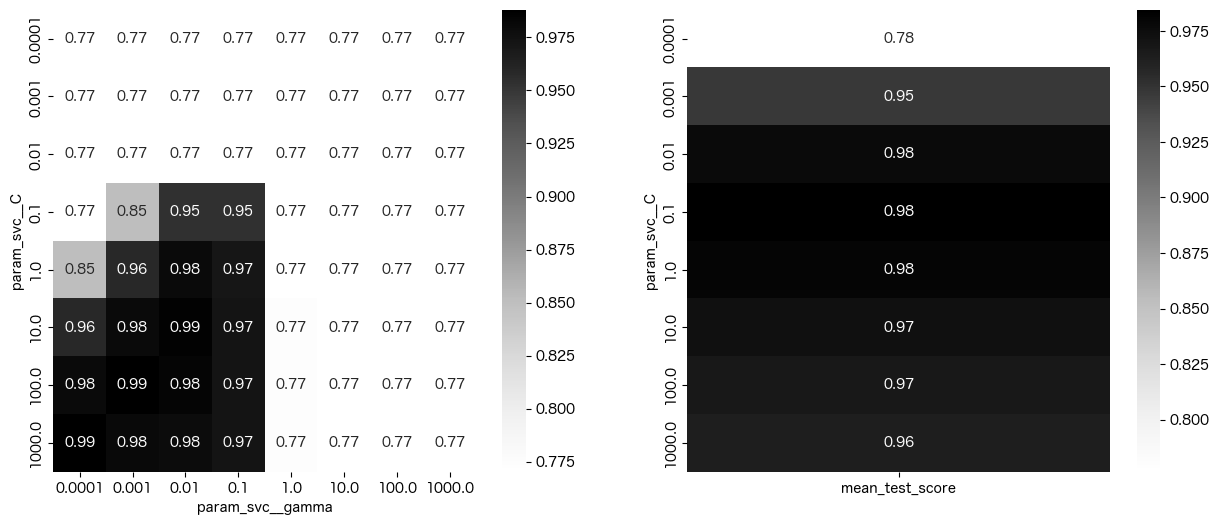

In [33]:
# GridSearchSVにおいて、F1スコアを指標にハイパーパラメータをチューニングしてみる

# Cとgammaの値の候補を作成する
c_gamma_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # 教科書とは値の範囲を変えている


# 線形カーネルとRBFカーネルそれぞれでチューニングするハイパーパラメータを決める
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

# make_scorerでF1スコアを出力させる(引数が2つ(正解値と予測値)足りない状態でscoreに保存する(カリー化された高階関数の部分適用))
scorer = make_scorer(f1_score, pos_label=0) # pos_labelで0/1どちらが陽性かを指定する

# GridSearchSVクラスのgsインスタンスを作成する
gs = GridSearchCV(estimator=pipe_svc, # 予測器としてpipe_svcインスタンスを渡す
                  param_grid=param_grid, # 値の候補を渡す
                  scoring=scorer, # scorerが出力する値で評価する
                  cv=10, # 10分割
                  n_jobs=-1) # CPUをフルに使う

# gsインスタンスでハイパーパラメータのチューニングを実行する
gs = gs.fit(X_train, y_train)


print(gs.best_score_)
print(gs.best_params_)

# 当然ヒートマップで示したくなる
cv_result = pd.DataFrame(gs.cv_results_)
cv_result_rbf = cv_result[cv_result['param_svc__kernel'] == 'rbf']
cv_result_linear = cv_result[cv_result['param_svc__kernel'] == 'linear']

cv_result_pivot_rbf = cv_result_rbf.pivot_table('mean_test_score', 'param_svc__C', 'param_svc__gamma')
cv_result_pivot_linear = cv_result_linear.pivot_table('mean_test_score', 'param_svc__C')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # プロットエリアを準備する

# 左: RBFカーネルでの、パラメータ（２つ）によるF1スコアの違い
heat_map = sns.heatmap(cv_result_pivot_rbf, cmap='Greys', annot=True, ax=ax1)
# 右: 線形カーネルでの、パラメータ（１つ）によるF1スコアの違い
heat_map = sns.heatmap(cv_result_pivot_linear, cmap='Greys', annot=True, ax=ax2)

In [34]:
# カリー化された高階関数の部分適用とは
def tasutasu(hiki1):
    return lambda hiki2: hiki1 + hiki2
tasu3 = tasutasu(3)
tasu3
# tasu3は、hiki2という引数を待っている関数として保存されている

<function __main__.tasutasu.<locals>.<lambda>(hiki2)>

In [35]:
# 正解率を指標にチューニングしたときと、選ばれた組み合わせは同じ

## 6.5.3 ROC曲線をプロットする

In [36]:
# 複数の分類モデルを比較評価するときの指標として、AUCがある
# AUC(曲線下面積)は、ROC曲線よりも下の部分の面積のことである

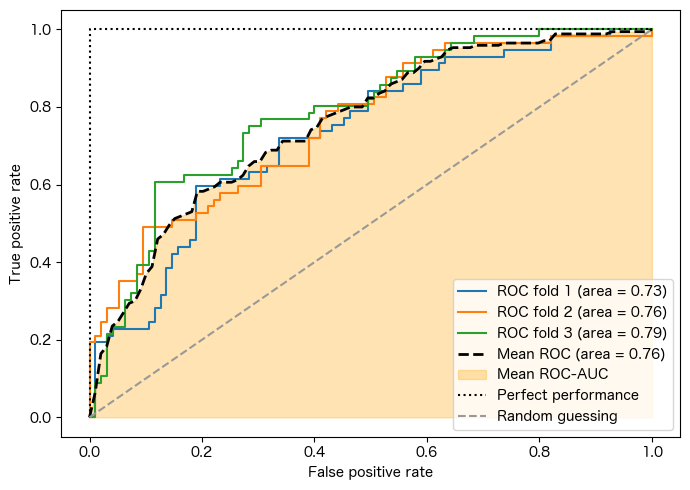

In [37]:
# ROC曲線を描く

# pipe_lrインスタンスを作成する
pipe_lr = make_pipeline(StandardScaler(), # 標準化器をセットする
                        PCA(n_components=2), # 主成分分析器をセットする
                        LogisticRegression(penalty='l2', # 予測器としてロジスティック回帰をセットする
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

# 説明変数として'周囲_平均'と'周囲_標準誤差'だけを使用する
X_train2 = X_train[:, [4, 14]]
    

# クラス比の不均衡に対応した層化3分割により学習用データを3分割する
# 3行2列のリスト
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# プロットエリアを準備する
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0

# 0から1までを100等分した等差数列
mean_fpr = np.linspace(0, 1, 100)

# 3つのデータセットでそれぞれROC曲線を描く
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test]) # 良性/陰性それぞれに分類される確率を求める

    fpr, tpr, thresholds = roc_curve(y_train[test], # ROC曲線
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) # 曲線の下側面積を計算する
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

# 3つのデータセットの平均でROC曲線を描く
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# 平均ROC曲線においてAUCをオレンジに塗る
plt.fill_between(mean_fpr, [0 for _ in mean_tpr], mean_tpr, color="orange", alpha=0.3, label="Mean ROC-AUC")

# 理想的な分類器によるROC曲線をプロット
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

# ランダムな推定をする分類器によるROC曲線をプロット
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

# グラフの体裁を整える
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()

In [38]:
# ROC曲線の意味を理解するための例: 

# 以下のように、正解ラベルと、予測モデルによる予測結果(ラベル1である確率)のペアがあったとする
y_true = [0, 0, 0, 0, 1, 1, 1, 1]
y_score = [0.2, 0.3, 0.6, 0.8, 0.4, 0.5, 0.7, 0.9]
df = pd.DataFrame(list(zip(y_true,y_score)), columns = ['正解','予測'])
display(df)

,正解,予測
0,0,0.2
1,0,0.3
2,0,0.6
3,0,0.8
4,1,0.4
5,1,0.5
6,1,0.7
7,1,0.9


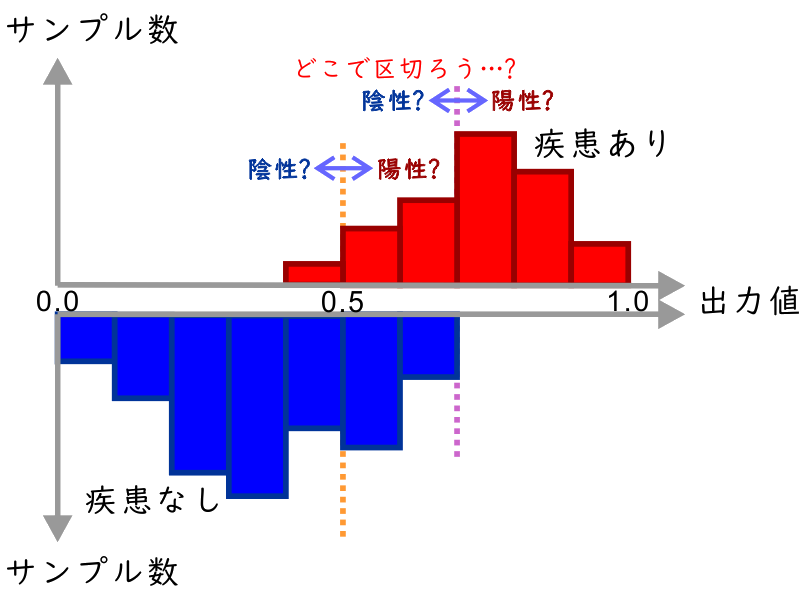

,閾値,真陽性数,偽陽性数,真陽性率,偽陽性率
0,1.9,0,0,0.00,0.00
1,0.9,1,0,0.25,0.00
2,0.8,1,1,0.25,0.25
3,0.7,2,1,0.50,0.25
4,0.6,2,2,0.50,0.50
5,0.4,4,2,1.00,0.50
6,0.2,4,4,1.00,1.00


In [39]:
# 予測がx%よりも大きい時に陽性と判定することにする。xを少しずつ小さくしていくと、真陽性者率と偽陽性者率が変化していく。
display(Image(data='https://www.cresco.co.jp/blog/wp-content/uploads/2020/12/classify3.png', retina=True))
# 出典: https://www.cresco.co.jp/blog/entry/15337/

_, _, thresholds = roc_curve(y_true, y_score)

df2 = pd.DataFrame({'閾値': thresholds})
df2 = df2.assign(真陽性数 = [((df['予測'] >= i) & (df['正解'] == 1)).sum() for i in thresholds])
df2 = df2.assign(偽陽性数 = [((df['予測'] >= i) & (df['正解'] == 0)).sum() for i in thresholds])
df2 = df2.assign(真陽性率 = df2['真陽性数'] / 4)
df2 = df2.assign(偽陽性率 = df2['偽陽性数'] / 4)

display(df2)

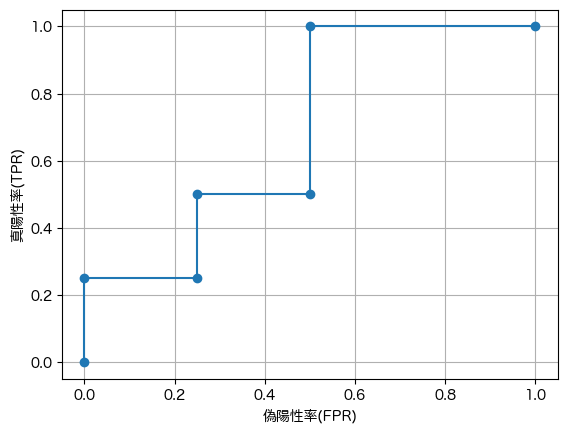

In [40]:
# この偽陽性率と真陽性率のペアをプロットしたものがROC曲線。
plt.plot(df2['偽陽性率'], df2['真陽性率'], marker='o')
plt.xlabel('偽陽性率(FPR)')
plt.ylabel('真陽性率(TPR)')
plt.grid()

,正解,予測
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1


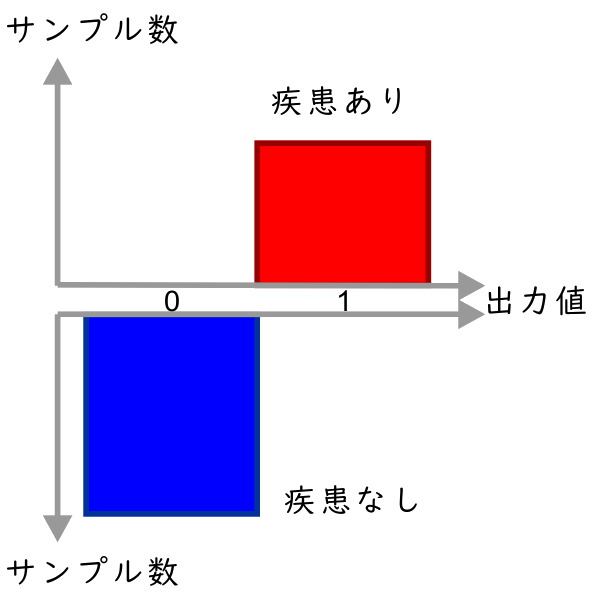

,閾値,真陽性数,偽陽性数,真陽性率,偽陽性率
0,2.0,0,0,0.0,0.0
1,1.0,4,0,1.0,0.0
2,0.8,4,0,1.0,0.0
3,0.6,4,0,1.0,0.0
4,0.4,4,0,1.0,0.0
5,0.2,4,0,1.0,0.0
6,0.0,4,4,1.0,1.0


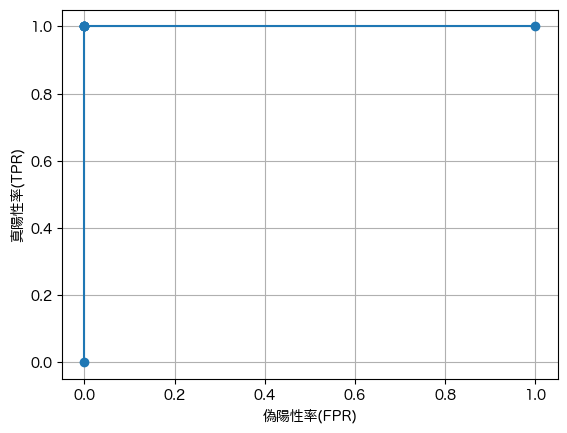

In [41]:
# 完璧な分類器とは？
df3 = pd.DataFrame({'正解': [0, 0, 0, 0, 1, 1, 1, 1],'予測': [0, 0, 0, 0, 1, 1, 1, 1]})
display(df3)

display(Image('https://www.cresco.co.jp/blog/wp-content/uploads/2020/12/classify1.png', retina=True))
# 出典: https://www.cresco.co.jp/blog/entry/15337/

df4 = pd.DataFrame({'閾値': [2, 1, 0.8, 0.6, 0.4, 0.2, 0]})
df4 = df4.assign(真陽性数 = [0, 4, 4, 4, 4, 4, 4])
df4 = df4.assign(偽陽性数 = [0, 0, 0, 0, 0, 0, 4])
df4 = df4.assign(真陽性率 = df4['真陽性数'] / 4)
df4 = df4.assign(偽陽性率 = df4['偽陽性数'] / 4)
display(df4)

plt.plot(df4['偽陽性率'], df4['真陽性率'], marker='o')
plt.xlabel('偽陽性率(FPR)')
plt.ylabel('真陽性率(TPR)')
plt.grid()

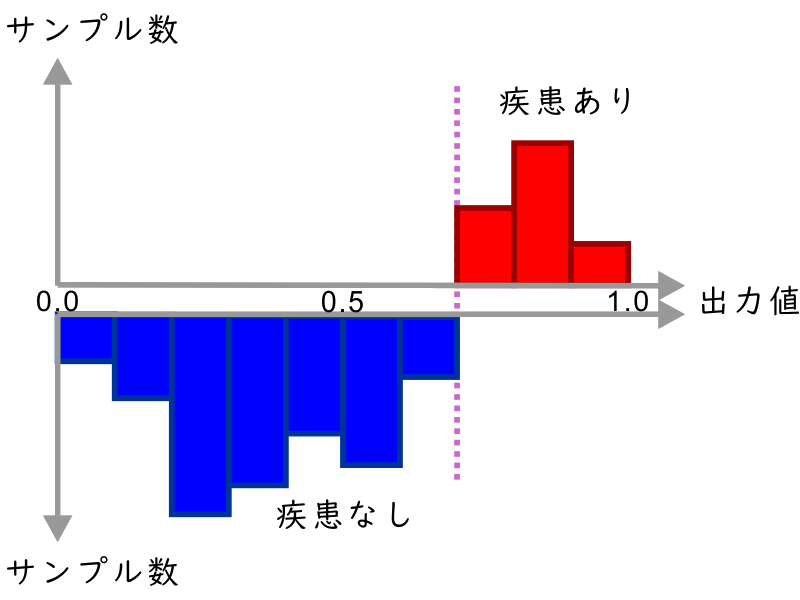

In [42]:
# 現実的に理想的な分類器？
display(Image('https://www.cresco.co.jp/blog/wp-content/uploads/2020/12/classify2.png', retina=True))
# 出典: https://www.cresco.co.jp/blog/entry/15337/

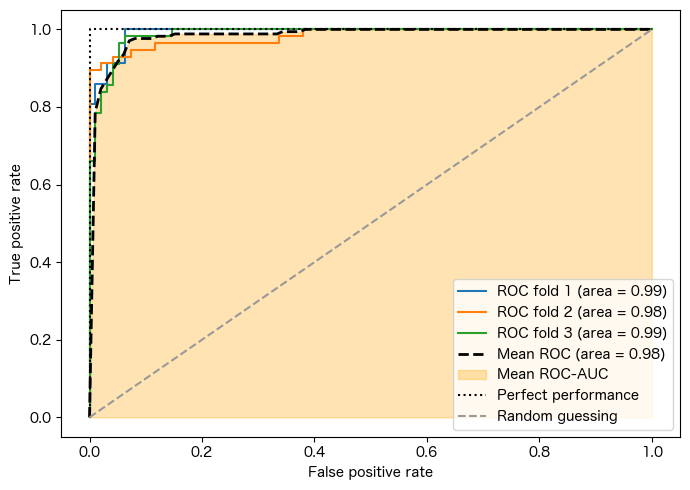

In [43]:
# ちなみに: すべての説明変数を使ったモデルでROC曲線を描く

# pipe_lrインスタンスを作成する
pipe_lr = make_pipeline(StandardScaler(), # 標準化器をセットする
                        PCA(n_components=2), # 主成分分析器をセットする
                        LogisticRegression(penalty='l2', # 予測器としてロジスティック回帰をセットする
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

# 説明変数として'周囲_平均'と'周囲_標準誤差'だけを使用する
X_train3 = X_train[:, :]
    

# クラス比の不均衡に対応した層化3分割により学習用データを3分割する
# 3行2列のリスト
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

# プロットエリアを準備する
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0

# 0から1までを100等分した等差数列
mean_fpr = np.linspace(0, 1, 100)

# 3つのデータセットでそれぞれROC曲線を描く
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train3[train],
                         y_train[train]).predict_proba(X_train3[test]) # 良性/陰性それぞれに分類される確率を求める

    fpr, tpr, thresholds = roc_curve(y_train[test], # ROC曲線
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) # 曲線の下側面積を計算する
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

# 3つのデータセットの平均でROC曲線を描く
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# 平均ROC曲線においてAUCをオレンジに塗る
plt.fill_between(mean_fpr, [0 for _ in mean_tpr], mean_tpr, color="orange", alpha=0.3, label="Mean ROC-AUC")

# 理想的な分類器によるROC曲線をプロット
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

# ランダムな推定をする分類器によるROC曲線をプロット
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

# グラフの体裁を整える
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()

## 6.5.4 多クラス分類のための性能指標

In [44]:
# sklearn.metrics.precision_scoreには、averageという引数がある
# averageは {'None', 'micro', 'macro', 'samples', 'weighted', 'binary'}の6つから選べる:

# None…陽性とするクラスを入れ替え、それぞれのパターンで算出した割合がそのまま出てくる。つまり、クラスの個数だけ値が出力される。
# macro…陽性とするラベルを入れ替え、それぞれのパターン算出した割合の、算術平均をとる。つまり、値は1つしか出力されない。
# weighted…macroの加重平均バージョン。ラベルの不均衡を反映した平均となる。値は1つしか出力されない。
# micro…陽性とするラベルを入れ替え、全体で合算したTP,TN,FP,FNをもとに算出した割合。つまり、値は1つしか出力されない。
# samples…それぞれのデータ点で算出し、それの平均を出力する。つまり、値は1つしか出力されない。ほとんどの場合正解率と同じになる？
# binary…pos_labelで指定されたクラスを陽性とした場合のみの結果を出力する。つまり、値は1つしか出力されない。予測もバイナリである必要がある。

# sklearn.metrics.make_scorerはprecision_scoreのラッパー関数なので同じようにaverageが選べる

In [45]:
display(Image(url='https://pystyle.info/wp/wp-content/uploads/2020/06/ml-accuracy-precision-recall-f-measure_06.svg'))
print('↑多クラスのときの、TP, TN, FP, FNの位置\n\n\n')

display(Image(url='https://pystyle.info/wp/wp-content/uploads/2020/06/ml-accuracy-precision-recall-f-measure_07.svg'))
print('↑Precissionにおけるマクロ平均の求め方\n\n\n')

display(Image(url='https://pystyle.info/wp/wp-content/uploads/2020/06/ml-accuracy-precision-recall-f-measure_09.svg'))
print('')

# 出典: https://pystyle.info/ml-accuracy-precision-recall-f-measure/

↑多クラスのときの、TP, TN, FP, FNの位置





↑Precissionにおけるマクロ平均の求め方





In [46]:
# ２値分類で考えた場合:


In [47]:
# マイクロ平均は、陽性・陰性を入れ替えたそれぞれの状態でのTPやFP, FNの合計から適合率などを算出する
# マクロ平均。陽性・陰性を入れ替えて算出した2つの値の算術平均となる。

適合率(Precision, 精度)… 陽性判定が出たひとに占める、本当に陽性の割合
$$
適合率(PRE) = \frac{真陽性数}{真陽性数+偽陽性数}
$$

In [48]:
# マクロ平均は、

In [49]:
# average

# 上のF1スコアによるハイパーパラメータチューニングでは、pos_labelで陽性=1と指定していた


In [50]:
# 教科書では「平等に重み付け」としているが、ふつうは「重み付けしていない」と表すとおもう

# × PREmicroは各インスタンス・予測を平等に重み付け　→ ◯ PREmicroは各インスタンス・予測について重み付けせず
# × PREmacroは各クラスを平等に重み付け → ◯ PREmacroは各クラスについて重み付けせず

In [51]:
# 教科書ではPREmicroとPREmacroつまり適合率のマイクロ/マクロ平均の話しか書いていないが、
# 再現率、そしてF1スコアにもマイクロ/マクロ平均の区別はある

# 6.6 クラスの不均衡に対処する

In [52]:
# たとえば良性90%、悪性10%のデータセットにおいて、
# すべてのデータ点に対して「良性」と答えるだけのモデルは、それだけで正解率90%を叩き出してしまう。【評価】
# また、モデルの学習とは、各データ点におけるコストや報酬を合計し、これを最小化・最大化することだが、
# 偏りがあると、データセットの大多数を占めるクラスに引き寄せられた学習結果となってしまう。【学習】

# モデルの評価においての対策は、
# 正解率以外の指標(適合率、再現率、ROC曲線など)を用いること

# モデルの学習においての対策は、
# ①少数派クラスに関する誤った予測に大きなペナルティを科すこと。
# ②少数派クラスを無作為コピペによって増やすこと(アップサンプリング)、多数派を間引くこと(ダウンサンプリング)。
# ③人工的に架空の新しい学習用データを生成すること(SMOTE)。

# 第06章 練習問題
https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/exercises/ch06

1) 2値分類タスク（かなりバランスのとれたクラスがある）において、AUCがモデル選択のための信頼できる性能指標でないのはどのような場合か？我々は一般的なケースを見ています。ヒントとして、2つのモデルのROC曲線をプロットしたと仮定して、これらのモデルを比較するのにAUCが単純すぎる場合について考えてみてください。

## 関連するが範囲外
このセクションの演習は、この章を読んだだけでは解けないので、さらに読み込んで研究する必要があります。

1) 次の段落で、'__'をa-cの文字に置き換えて、次のように定義しなさい。
- a): アウトオブバッグ(OOB)ブートストラップ
- b): .632 ブートストラップ
- c): .632+ブートストラップ

"汎化性能の推定には、_(1)は_より楽観的に偏りにくく、(1)と_は_より悲観的に偏りにくい。"

この問いに答えるための推奨図書

セバスチャン・ラシュカ(2018). 機械学習におけるモデル評価、モデル選択、アルゴリズム選択.
https://arxiv.org/abs/1811.12808